In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import math

In [2]:
# Import AAPL data
raw_data = pd.read_csv('./data/aapl_1y.csv', index_col='date')
raw_data.head()

,open,high,low,close,volume
date,,,,,
5/30/19,177.95,179.23,176.67,178.30,21218412
5/29/19,176.42,179.35,176.00,177.38,28481164
5/28/19,178.92,180.59,177.91,178.23,27948160
5/24/19,180.20,182.14,178.62,178.97,23714686
5/23/19,179.80,180.54,177.81,179.66,36529736


# Define Security Class
This class holds information for securities that will be used for PnF charting

In [3]:
class Security:
    def __init__(self, data, date_format='%Y-%m-%d'):
        self._data = data # Date-indexed OHLC data
        self._chart = None
        self._pnf_bars = None
        self._pnf_points = None
        self._pnf_columns = None
        self._default_format = '%Y-%m-%d'
        self._date_format = date_format
        
        # Ensure that index of data is of format %Y-%m-%d
        self.format_index()
        
    @property
    def data(self):
        return self._data
    
    @data.setter
    def data(self, d):
        # Ensure data has correct columns and date index
        required_cols = set(['close', 'high', 'low'])
        cols = set(d.columns)
        if len(required_cols.intersection(cols)) != len(required_cols):
            raise ValueError("Security data doesn't contain all required columns: ('close', 'high', 'low')")
        self._data = d
        #else:
            # Check index is of right dtype
            #required_type = pd._libs.tslib.Timestamp
            #if d.index.dtype != required_type:
            #    raise ValueError("Security data needs to have index values of type pd.Timestamp")
            #else:
                #self._data = d
                
    @property
    def pnf_points(self):
        return self._pnf_points
    
    @pnf_points.setter
    def pnf_points(self, p):
        if len(p) == 0:
            raise ValueError('List of PnF points can not be empty')
        if not type(p[0][0]) == PnfPoint:
            raise ValueError('PnF points in list must be of type PnfPoint')
        self._pnf_points = p
        
    @property
    def chart(self):
        return self._chart
    
    @chart.setter
    def chart(self, c):
        if type(c) != Chart:
            raise ValueError('self._chart must be of type Chart')
        self._chart = c
        
    @property
    def pnf_bars(self):
        return self._pnf_bars
    
    @pnf_bars.setter
    def pnf_bars(self, pb):
        if type(pb) != pd.DataFrame:
            raise ValueError('self._pnf_bars must be a pd.DataFrame')
        self._pnf_bars = pb
        
    @property
    def pnf_points(self):
        return self._pnf_points
    
    @pnf_points.setter
    def pnf_points(self, p):
        if len(p) == 0:
            raise ValueError('self._pnf_points cannot be empty')
        if type(p[0]) != PnfPoint:
            raise ValueError('Elements in self._pnf_points must be of type PnfPoint')
        self._pnf_points = p
        
    @property
    def pnf_columns(self):
        return self._pnf_columns
    
    @pnf_columns.setter
    def pnf_columns(self, c):
        if len(c) == 0:
            raise ValueError('self._pnf_columns cannot be empty')
        if type(c[0]) != PnfColumn:
            raise ValueError('self._pnf_columns must be a list of PnfColumn objects')
        self._pnf_columns = c
        
    @property
    def date_format(self):
        return self._date_format
    
    @date_format.setter
    def date_format(self, df):
        if type(df) != type(str):
            raise ValueError('self.date_format must be a date format string')
            
        self._date_format = df
        
    def format_index(self):
        '''
            Formats self._data index so that it is in format %Y-%m-%d
        '''
        idx = pd.Series(self.data.index)
        idx = idx.apply(lambda d: datetime.strptime(d, self.date_format))
        idx = idx.apply(lambda d: datetime.strftime(d, '%Y-%m-%d'))
        self.data.index = idx
        
    def generate_pnf_data(self, method='trad'):
        '''
            Generates PnF data necessary for plotting/bar creation
        '''
        # Create chart instance
        self._chart = Chart(self._data)
        # Get PnfPoints
        self._chart.generate_pnf_points(scaling=method)
        self._pnf_points = self._chart._pnf_points
        # Get Pnf Columns
        self._chart.generate_pnf_columns()
        self._pnf_columns = self._chart._columns
        
    def plot_chart(self):
        '''
            Generates a PnF Chart
        '''
        if self._chart == None:
            raise ValueError('Chart not instantiated. Please call self.generate_pnf_data before \
            calling self.plot_chart')
        else:
            self._chart.plot_chart()
        
    def generate_pnf_bars(self):
        '''
            Generates PnF bars using self._pnf_points
            
            Args:
                None
                
            Returns:
                (pd.DataFrame): dataframe of PnF bars
        '''
        # Generate rough dataframe from _pnf_points
        pnf_df = pd.DataFrame()
        for p in self._pnf_points:
            pnf_df = pnf_df.append(pd.DataFrame.from_dict({
                'date': [p.date],
                'direction': [p.direction],
                'value': [p.value],
                'double_top': [p._signals['double_top']],
                'double_bottom': [p._signals['double_bottom']],
                'triple_top_break': [p._signals['triple_top_break']],
                'triple_bottom_break': [p._signals['triple_bottom_break']],
            }))
        
        pnf_df = pnf_df.reset_index().drop(['index'], axis=1)
        
        # Find time between ticks
        pnf_df['date'] = pnf_df.date.apply(lambda d: datetime.strptime(d, self._default_format))
        pnf_df['timedelta'] = pnf_df.date - pnf_df.date.shift(1)
        
        # Change index to date
        pnf_df = pnf_df.set_index('date')
        pnf_df.dropna(inplace=True)
        
        # Aggregate data so only one tick per day
        dates = pnf_df.index.unique()
        agg_df = pd.DataFrame()
        for date in dates:
            # Get all bars for this date
            date_df = pnf_df.loc[[date]]
            # Get attributes
            direction = date_df.iloc[0].direction
            timedelta = np.max(date_df.timedelta)
            # Get signals
            double_top = True in date_df['double_top'].values
            double_bottom = True in date_df['double_bottom'].values
            triple_top_break = True in date_df['triple_top_break'].values
            triple_bottom_break = True in date_df['triple_bottom_break'].values
            # Get signals
            if direction == 'x':
                value = np.max(date_df.value)
            else:
                value = np.min(date_df.value)

            # Append aggregated row to df
            agg_df = agg_df.append(pd.DataFrame.from_dict({
                'value': [value],
                'direction': [direction],
                'timedelta': [timedelta],
                'double_top': [double_top],
                'double_bottom': [double_bottom],
                'triple_top_break': [triple_top_break],
                'triple_bottom_break': [triple_bottom_break],
                'date': [date]
            }))

        agg_df = agg_df.set_index('date')
        self._pnf_bars = agg_df

# Define PnfPoint Class
This class represents the data for a point on our PnF chart

In [4]:
class PnfPoint:
    def __init__(self, direction, value, date, marker):
        self._direction = direction
        self._value = value
        self._date = date
        self._marker = marker
        self._signals = {
            'double_top': False,
            'double_bottom': False,
            'triple_top_break': False,
            'triple_bottom_break': False,
        }
        
    def __str__(self):
        '''
            Overloaded print function
        '''
        return 'Date: {} | Value: {} | Dir: {} |  Signals: {}'.format(self._date, 
                                                                      self._value, 
                                                                      self._direction,
                                                                      self._signals)
        
    @property
    def direction(self):
        return self._direction
    
    @direction.setter
    def direction(self, d):
        self._direction = d
        
    @property
    def value(self):
        return self._value
    
    @value.setter
    def price(self, v):
        self._value = v
        
    @property
    def date(self):
        return self._date
    @date.setter
    def date(self, d):
        self._date = d
        
    @property
    def marker(self):
        return self._marker
    
    @marker.setter
    def marker(self, m):
        self._marker = m

# Define a Column Class
This will hold a set of points corresponding to a column on a PnfChart

In [5]:
class PnfColumn:
    def __init__(self, points, direction):
        self._pnf_points = points
        self._direction = direction
        self._max = self.get_max_value()
        self._min = self.get_min_value()
        
    @property
    def pnf_points(self):
        return self._pnf_points
    
    @pnf_points.setter
    def pnf_points(self, points):
        if len(points) == 0:
            raise ValueError('self._pnf_points cannot be empty')
        if type(points[0]) != PnfPoint:
            raise ValueError('self._pnf_points must be an iterable with elements of type PnfPoint')
        
        # May want to enforce some sorting here
        self._pnf_points = points    
        
    @property
    def direction(self):
        return self._direction
    
    @direction.setter
    def direction(self, d):
        if type(d) != type(str):
            raise ValueError('self._direction must be a string')
        if d.lower() not in ['x', 'o']:
            raise ValueError('self._direction must be either "x" or "o"')
            
        self._direction = d
        
    def get_max_value(self):
        # Iterate through all points and find one with highest value
        max_val = 0
        
        for p in self._pnf_points:
            if p._value > max_val:
                max_val = p._value
                
        return max_val    
        
    
    def get_min_value(self):
        # Iterate through all points and find the one with the lowest value
        min_val = 1e9
        for p in self._pnf_points:
            if p._value < min_val:
                min_val = p._value
                
        return min_val

# Define a Chart Class
This class will be used to calculate and plot the PnF events for a given security

In [6]:
class Chart:
    def __init__(self, data):
        self._data = data
        self._pnf_points = []
        self._columns = []
        self._boxes = []
        self._scale_methods = ['trad', 'pct']
        
    @property
    def data(self):
        return self._data
    
    @data.setter
    def data(self, d):
        # Ensure data has correct columns and date index
        required_cols = set(['close', 'high', 'low'])
        cols = set(d.columns)
        if len(required_cols.intersection(cols)) != len(required_cols):
            raise ValueError("Security data doesn't contain all required columns: ('close', 'high', 'low')")
        else:
            # Check index is of right dtype
            required_type = pd._libs.tslib.Timestamp
            if d.index.dtype != required_type:
                raise ValueError("Security data needs to have index values of type pd.Timestamp")
            else:
                self._data = d
    
    @property
    def pnf_points(self):
        return self._pnf_points
    
    @pnf_points.setter
    def pnf_points(self, p):
        if len(p) == 0:
            raise ValueError('List of PnF points can not be empty')
        if not type(p[0][0]) == PnfPoint:
            raise ValueError('PnF points in list must be of type PnfPoint')
        self._pnf_points = p
        
    @property
    def columns(self):
        return self._columns
    
    @columns.setter
    def columns(self, c):
        if len(c) == 0:
            raise ValueError('PnF Columns cannot be empty')
        if not type(c[0]) != PnfColumn:
            raise ValueError('Columns must be of type PnfColumn')
        
        self._columns = c
        
    @property
    def boxes(self):
        return self._boxes
    
    @boxes.setter
    def boxes(self, b):
        if type(b) != pd.Series:
            raise ValueError('self._boxes must be of type pd.Series')
        self._boxes = b
        
    def get_trad_box_increment(self, value):
        '''
            Gets the box size for traditional box sizing method
            
            Args:
                value (numeric): the value whose increment we are returning
                
            Returns:
                (numeric): a box increment value dependent upon input value
        '''

        scale_dict = {
        0: 0.0625,
        0.25: 0.125,
        1: 0.25,
        5: 0.5,
        20: 1.0,
        100: 2.0,
        200: 4.0,
        500: 5.0,
        1000: 50.0,
        25000: 500.0
    }
        # Get possible ranges
        ranges = sorted(list(scale_dict.keys()))
        # Find price range
        scale_key = 1
        for r in ranges:
            if value >= r:
                scale_key = r
            else:
                break

        return scale_dict[scale_key]
        
        
    def generate_boxes(self, value=0, method='trad'):
        '''
            Generate a series of values representing the boxes of a pnf chart.
            
            Args:
                value (numeric): value around which to generate box sizes (optional for 
                                    'trad' scaling method)
                method (str): the scaling method to use. See self.valid_methods
                
            Returns:
                None. Sets self._boxes to a pd.Series
        '''
        # Ensure that method is valid
        if method not in self._scale_methods:
            raise ValueError('Unknown scaling method passed. Options are: {}'.format(self._scale_methods))
            
        # If method is traditional, then boxes will always be the same. Generate them
        # up to $2000
        max_val = 2000
        boxes = []
        if method == 'trad':
            boxes.append(0)
            while boxes[-1] < max_val:
                inc = self.get_trad_box_increment(boxes[-1])
                boxes.append(boxes[-1] + inc)
                
        #If method is percentage, then we will generate 100 boxes above and below the value
        if method == 'pct':
            boxes_to_gen = 200
            boxes = [round(0.01 * ii * value, 2) for ii in range(boxes_to_gen)]
                
        # Set boxes
        self._boxes = pd.Series(boxes)
    
    def get_box_diff(self, val, prev_val, direction):
        '''
            Get the box difference between val and prev_val
            
            Args:
                val (numeric): the current value during pnf generation
                prev_val (numeric): the previous value plotted on the pnf chart
                direction (char, 'x' or 'o'): are we checking box differences for 
                            column of Xs or Os?
                
            Returns:
                (numeric): the number of boxes val has moved from prev_val
        '''
        
        
        if direction == 'x':
            # If determining Xs, need to look at boxes below
            prev_boxes = len(self._boxes[self._boxes <= prev_val])
            val_boxes = len(self._boxes[self._boxes <= val])
        else:
            # If determining Os, need to find boxes above
            prev_boxes = len(self._boxes[self._boxes >= prev_val])
            val_boxes = len(self._boxes[self._boxes >= val])
            #print('Val Boxes: {} | Prev Boxes: {} | Val: {} | Prev Val: {}'.format(val_boxes, prev_boxes, val, prev_val))
        
        
        # Get difference
        return val_boxes - prev_boxes
        
    
    def generate_pnf_points(self, scaling='trad'):
        '''
            Generate the PnF events for the chart's associated security
            
            Args: 
                scaling (str): method used to determine box sizes (see self.get_scale)
            
            Returns:
                Nothing. Events stored in self._pnf_points
                
        '''
        print('Length of chart dataset: {}'.format(len(self._data)))
        # Use first close as starting point
        self.prev_val = self.data.close[0]
        
        # If using 'trad' scaling method, get boxes now as they are fixed
        if scaling == 'trad':
            self.generate_boxes(method='trad')

        # Is the current column an X or O?
        col_is_x = False
        col_is_o = False
        
        # Iterate through data and calculate pnf events
        for ii, row in self._data.iterrows():
            # Skip the first day
            if(ii == self._data.index[0]):
                continue
                
            # For percentage based method, calculate boxes each iteration
            if scaling == 'pct':
                self.generate_boxes(value=self.prev_val, method='pct')
                
            # Get daily high and low
            high = row.high
            low = row.low
            
            # Find number of boxes between last box price and current
            # highs and lows. We will be concerned with positive difference
            # for X columns and negative differences for O columns
            high_box_diff = self.get_box_diff(high, self.prev_val, direction='x')
            low_box_diff = self.get_box_diff(low, self.prev_val, direction='o')
            
            # Determine how many boxes of movement are needed to add an X or O
            x_thresh = 1 if col_is_x else 3
            o_thresh = 1 if col_is_o else 3
            
            # Check edge case to see if both boxes broke their thresholds
            if high_box_diff >= x_thresh and low_box_diff >= o_thresh:
                # Check current column, and give priority to current symbol
                if col_is_x:
                    self.append_pnf_point('x', high_box_diff, date=ii)
                    col_is_x, col_is_o = True, False
                else:
                    self.append_pnf_point('o', abs(low_box_diff), date=ii)
                    col_is_o, col_is_x = True, False
            else:
                # If only one threshold broken, determine which one (if any) and append accordingly.
                if high_box_diff >= x_thresh:
                    self.append_pnf_point('x', high_box_diff, date=ii)
                    col_is_x, col_is_o = True, False

                if low_box_diff >= o_thresh:
                    self.append_pnf_point('o', abs(low_box_diff), date=ii)
                    col_is_o, col_is_x = True, False
                    
            # Set last value
            if len(self._pnf_points) > 0:
                self.prev_val = self._pnf_points[-1]._value
    
    def append_pnf_point(self, direction, diff, date):
        '''
            Append a new PnF point to self._pnf_points
            
            Args:
                direction (char): 'x' or 'o' -- direction of PnF Chart
                diff (int): number of boxes we've moved
                date (pd.Timestamp): date point was added to chart
                
            Returns:
                Nothing. New points are appended to self._pnf_points
        '''
        # Get index of previously charted box
        val_box_idx = self._boxes[self._boxes <= self.prev_val].idxmax()
        # Get date of previously charted value
        prev_date = self._pnf_points[-1].date if len(self._pnf_points) > 0 else None
        prev_month = datetime.strptime(prev_date, '%Y-%m-%d').month if prev_date != None else None
        app_seq = []
        for ii in range(1, diff+1):
            # Determine if we are moving up or down boxes
            box_dir = 1 if direction == 'x' else -1
            value = self._boxes[val_box_idx + (ii * box_dir)]
            # Determine what marker will be used to plot. If this is the first
            # plotted point of a month, we will use a special marker
            if datetime.strptime(date, '%Y-%m-%d').month != prev_month:
                marker = '^'
                prev_month = datetime.strptime(date, '%Y-%m-%d').month
            else:
                marker = direction
            # Create point
            point = PnfPoint(direction, value, date, marker)
            # Append point to sequence
            app_seq.append(point)

        # Append these PnF Points to chart's list
        if len(self._pnf_points) > 0:
            self._pnf_points += app_seq
        else:
            self._pnf_points = app_seq      
            
    def generate_pnf_columns(self):
        '''
            Take the points contained in self._pnf_points and generate the columns
            of the corresponding PnF chart
            
            Args:
                None
            
            Returns:
                None. Columns saved to self._columns
        '''
        prev_dir = ''
        column_points = []
        for ii, point in enumerate(self._pnf_points):
            # X or O?
            curr_dir = point._direction
            # If same as prev symbol, append to curr column
            if curr_dir == prev_dir:
                column_points[-1].append(point)
            else:
                # New column
                prev_dir = curr_dir
                column_points.append([point])
                
        # Once we have the points for each column, make PnfColumn objects
        for col in column_points:
            pnf_col = PnfColumn(points=col, direction=col[0]._direction)
            self._columns.append(pnf_col)
                
    def plot_chart(self):
        '''
            Plot the PnF Chart
        '''
        fig = plt.figure(1, figsize=(20, 10))
        ax = fig.add_subplot(111)
        for ii, col in enumerate(self._columns):
            # Plot each point in column
            for p in col._pnf_points:
                y = p.value
                x = ii+1
                direction = p.direction
                marker = p.marker
                # Make month transitions blue
                if marker == '^':
                    color = 'blue'
                else:
                    color = 'black' if direction == 'x' else 'red'
                # Plot points
                plt.scatter(x, y, color=color, marker=marker)


        # Set Y range for plot
        #low = int(np.min([p.price for l in self._columns for p in l]))
        #high = int(np.max([p.price for l in self._columns for p in l]))
        plt.grid(True)
        plt.show()

# Instantiate Security and Generate PnF Data

In [7]:
sec = Security(raw_data[::-1], date_format='%m/%d/%y')
sec.generate_pnf_data(method='trad')

Length of chart dataset: 272


# Use PnF Data to Make PnF Chart

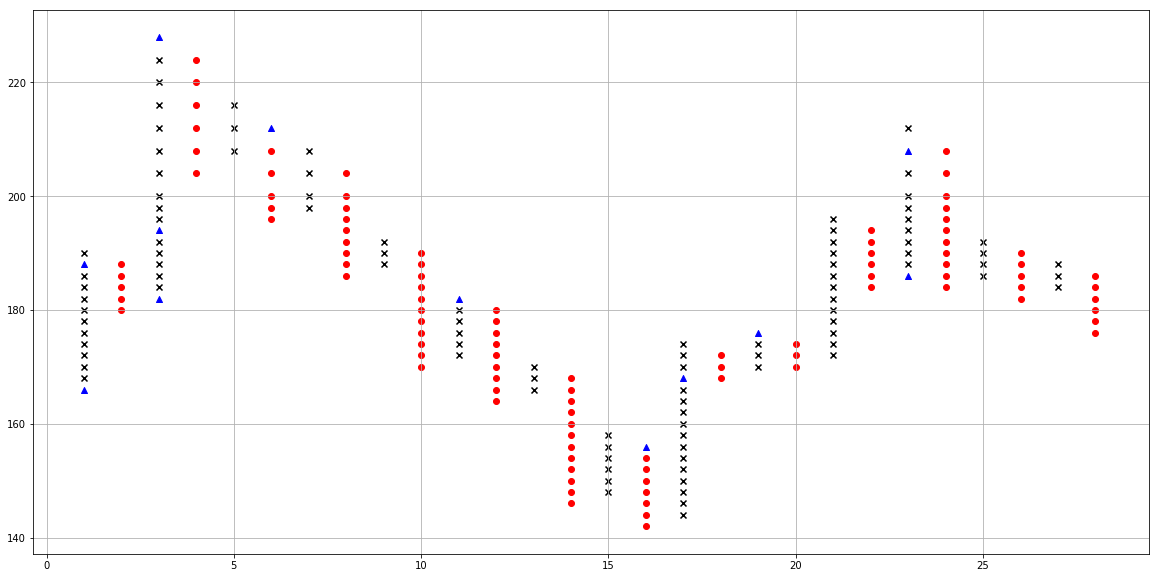

In [8]:
sec.plot_chart()

# Identify Buy/Sell Signals
We will create a class called PatternFinder which will be passed a list of lists of PnfPoints (chart columns) that can be used to identify common chart patterns.

In [9]:
class PatternFinder():
    def __init__(self, pnf_columns):
        self._columns = pnf_columns
        self._pnf_points = None
        
    @property
    def columns(self):
        return self._columns
    
    @columns.setter
    def columns(self, c):
        if len(c) == 0:
            raise ValueError('self._columns cannot be empty.')
        if type(c[0]) != PnfColumn:
            raise ValueError('self._columns must be a list of PnfColumn objects')
            
        self._columns = c
        
    @property
    def pnf_points(self):
        return self._pnf_points
    
    @pnf_points.setter
    def pnf_points(self, p):
        if len(p) == 0:
            raise ValueError('self._pnf_points cannot be empty.')
        if type(p[0]) != PnfPoint:
            raise ValueError('self._pnf_points must contain elements of type PnfPoint')
        self._pnf_points = p
        
        
    def point_from_cols(self):
        '''
            This will iterate through self._columns and will place each point into
            self._pnf_points
        '''
        points = []        
        for col in self._columns:
            for p in col._pnf_points:
                points.append(p)
                
        self._pnf_points = points
        
        
    def double_top_break(self):
        '''
            Identify where double top breaks occur (if at all) in the dataset. A double
            top breakout occurs when the current column of Xs exceeds the previous column
            of Xs 
            
            Returns:
                None. Appends double_top_break feature to PnfPoint._signals
        '''
        # Start by identifying all X columns
        x_col_idxs = []
        for ii, col in enumerate(self._columns):
            if col._direction == 'x':
                x_col_idxs.append(ii)
        
        # Find all successive pairs of X columns
        x_pairs = []
        for ii, idx in enumerate(x_col_idxs):
            # Break if we are at the last element and can't make a new pair
            if ii == len(x_col_idxs) - 1:
                break
            
            # Create pairs
            x_pairs.append((x_col_idxs[ii], x_col_idxs[ii+1]))
            
        # Go through all pairs. If the second column in the pair has a higher max
        # than the first, this is a double top breakout
        for pair in x_pairs:
            col1 = self._columns[pair[0]]
            col2 = self._columns[pair[1]]
            
            if col2._max > col1._max:
                # We have identified that a breakout has occurred in col2. Now
                # we must find the point responsible.
                for p in self._columns[pair[1]]._pnf_points:
                    if p._value > col1._max:
                        p._signals['double_top'] = True
                        break
                
    def double_bottom_break(self):
        '''
            A double bottom breakdown occurs when a column of Os dips lower than the previous
            column of Os
            
            Returns:
                None. Appends double_bottom key/value to PnfPoint._signals
        '''
        # First identify all O columns
        o_col_idxs = []
        for ii, col in enumerate(self._columns):
            if col._direction == 'o':
                o_col_idxs.append(ii)
                
        # Find all successive pairs of O columns
        o_pairs = []
        for ii, idx in enumerate(o_col_idxs):
            # Break if we don't have enough remaining points to create a pair
            if ii == len(o_col_idxs) - 1:
                break
            # Create pairs
            o_pairs.append((o_col_idxs[ii], o_col_idxs[ii+1]))
            
        # Go through all pairs. If the second column in the pair has a lower
        # min than the first column, this is a double bottom breakdown
        for pair in o_pairs:
            col1 = self._columns[pair[0]]
            col2 = self._columns[pair[1]]
            
            if col2._min < col1._min:
                # We've identified a double bottom breakdown in this column. Now
                # we must find the point responsible
                for p in self._columns[pair[1]]._pnf_points:
                    if p._value < col1._min:
                        p._signals['double_bottom'] = True
                        break
                
    def triple_top_break(self):
        '''
            A triple top breakout occurs when the chart reaches a certain X column level twice,
            before breaking through that level on the third column of Xs
            
            Returns:
                None. Appends triple_top_break key/value pair to PnfPoint._signals
        '''
        # From columns get all X columns
        x_col_idxs = []
        for ii, col in enumerate(self._columns):
            if col._direction == 'x':
                x_col_idxs.append(ii)
                
        # Create triplets of all successive x columns
        x_triplets = []
        for ii, idx in enumerate(x_col_idxs):
            # If we don't have enough remaining indices to make a triplet, break
            if ii == len(x_col_idxs) - 2:
                break
            # Create triplet
            triplet = (idx, x_col_idxs[ii+1], x_col_idxs[ii+2])
            x_triplets.append(triplet)
            
        # Check that first two in triplet hit same level, if they did, and third col
        # breaks that level, this is a triple top breakout
        for triplet in x_triplets:
            # Get Columns
            col1 = self._columns[triplet[0]]
            col2 = self._columns[triplet[1]]
            col3 = self._columns[triplet[2]]
            
            # First two cols hit same level
            if col1._max == col2._max:
                # Col 3 exceeds two column level
                if col3._max > col1._max:
                    # We know that a triple top break has occurred in 
                    # this column, now we must find the point responsible
                    for p in self._columns[triplet[2]]._pnf_points:
                        if p._value > col1._max:
                            p._signals['triple_top_break'] = True
                            break
                            
    def triple_bottom_break(self):
        '''
            A triple bottom break occurs when two successive columns of Os dip down to the same
            level, and the next column of Os breaks through that level.
            
            Returns:
            None. Appends triple_bottom_break key/value pair to PnfPoint._signals
        '''
        # First we identify all O columns
        o_col_idxs = []
        for ii, col in enumerate(self._columns):
            if col._direction == 'o':
                o_col_idxs.append(ii)
                
        # Next we create a triplet of all successive 3 O columns
        triplets = []
        for ii, idx in enumerate(o_col_idxs):
            # Break if we are at end of idxs and can't create another triplet
            if ii == len(o_col_idxs) - 2:
                break
            # Create triplets
            triplet = (o_col_idxs[ii], o_col_idxs[ii+1], o_col_idxs[ii+2])
            triplets.append(triplet)
            
        # Go through all triplets. If first two cols in triplet have same min level, and
        # third col has a lower level, this is a triple bottom breakdown
        for triplet in triplets:
            col1 = self._columns[triplet[0]]
            col2 = self._columns[triplet[1]]
            col3 = self._columns[triplet[2]]
            
            # First two cols have same min value
            if col1._min == col2._min:
                # Third column breaks through min
                if col3._min < col1._min:
                    # We have identified a triple bottom break in this column.
                    # Now we must find the point responsible
                    for p in self._columns[triplet[2]]._pnf_points:
                        if p._value < col1._min:
                            p._signals['triple_bottom_break'] = True
                            break
                

In [10]:
# Init pattern finder with columns of security chart
pf = PatternFinder(sec._pnf_columns)

# Calculate signal occurrences
pf.double_top_break()
pf.double_bottom_break()
pf.triple_top_break()
pf.triple_bottom_break()

# After getting all patterns, set points back to security
pf.point_from_cols()
sec._pnf_points = pf._pnf_points

# Use PnF Data to Generate Bars

In [11]:
sec.generate_pnf_bars()
sec._pnf_bars.head(15)

,direction,double_bottom,double_top,timedelta,triple_bottom_break,triple_top_break,value
date,,,,,,,
2018-05-02,x,False,False,0 days,False,False,174.0
2018-05-04,x,False,False,2 days,False,False,180.0
2018-05-07,x,False,False,3 days,False,False,184.0
2018-05-10,x,False,False,3 days,False,False,186.0
2018-06-04,x,False,False,25 days,False,False,190.0
2018-06-19,o,False,False,15 days,False,False,182.0
2018-06-25,o,False,False,6 days,False,False,180.0
2018-07-09,x,False,False,14 days,False,False,186.0
2018-07-10,x,False,False,1 days,False,False,188.0


# Define a Relative Strength Class
This class will be able to do all relevant RS calculations between two assets

In [12]:
class RSInstrument(Security):
    def __init__(self, num, den, date_format='%Y-%m-%d'):
        # Set numerator and denominator of RS Calc
        self._num_sec = num 
        self._den_sec = den 
        
        # Create the combined dataset by dividing metrics from numerator
        # by the metrics of the denominator
        self.get_rs_data()
        
        # Initialize security using the quotient data
        Security.__init__(self, self._data, date_format=date_format)
        
    @property
    def num_sec(self):
        return self._num_sec
    
    @num_sec.setter
    def num_sec(self, ns):
        if type(ns) != pd.DataFrame:
            raise ValueError('self._num_sec must be of type pd.DataFrame')
        self._num_sec = ns
        
    @property
    def den_sec(self):
        return self._den_sec
    
    @den_sec.setter
    def den_sec(self, ds):
        if type(ds) != pd.DataFrame:
            raise ValueError('self._den_sec must be of type pd.DataFrame')            
        self._den_sec = ds
        
    def get_rs_data(self):
        '''
            Take data from numerator and divide by data in denominator to get the data
            required to create the RS chart
        '''
        # Do some sort of index checking here to ensure that data actually occurs during
        # the same time frame
        combined_idx = self._num_sec.index.union(self._den_sec.index)
        data = self._num_sec.join(self._den_sec, lsuffix='_num', rsuffix='_den')
        
        # Forward fill to account for any times when either the num/den did not have data
        data.fillna(method='ffill', inplace=True)
        
        # Get the quotient data --  divide numerator values by denominator closes
        data['open'] = data['open_num'] / data['close_den']
        data['high'] = data['high_num'] / data['close_den']
        data['low'] = data['low_num'] / data['close_den']
        data['close'] = data['close_num'] / data['close_den']
        data['volume'] = data['volume_num'] / data['volume_den']
        
        # Multiply all quotients by 100 to get percentage points instead of decimals
        self.data = data[['open', 'high', 'low', 'close', 'volume']]
        self.data *= 100.      
        

In [13]:
# Test out RSInstrument
msft_df = pd.read_csv('./data/msft_5y.csv', index_col='date')
aapl_df = pd.read_csv('./data/aapl_5y.csv', index_col='date')

msft_df = msft_df.loc[::-1]
aapl_df = aapl_df.loc[::-1]

Length of chart dataset: 1279


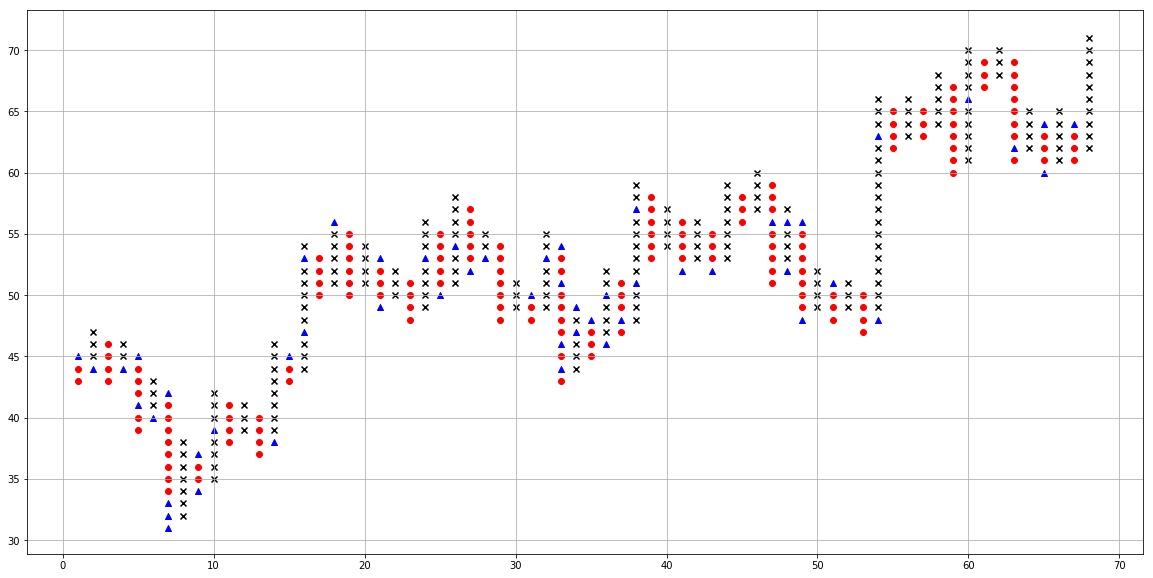

In [14]:
rsi = RSInstrument(num=msft_df, den=aapl_df, date_format='%m/%d/%y')
rsi.generate_pnf_data()
rsi.plot_chart()